# Determining the point-spread-function from a bead image by averaging
In order to deconvolve a microsocpy image properly, we should determine the point-spread-function (PSF) of the microscope.

See also 
* [PSF destilling by Brian Northan](https://github.com/True-North-Intelligent-Algorithms/tnia-python/blob/main/notebooks/Deconvolution/extract_psf-Haase-beads.ipynb)

In [1]:
import numpy as np
from skimage.io import imread, imsave
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import pandas as pd
import matplotlib.pyplot as plt
from os import path

The example image data used here was acquired by Bert Nitzsche and Robert Haase (both MPI-CBG at that time) at the Light Microscopy Facility of MPI-CBG. Just for completeness, the voxel size is 0.022x0.022x0.125 µm^3.

In [24]:
# must convert ome.tif into regular tif first, otherwise has bug
beads_imgpath = [
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view02.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view03.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view04.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view05.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view06.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view07.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view08.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view09.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view10.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view11.ome.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view02.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view03.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view04.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view05.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view06.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view07.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view08.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view09.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view10.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view11.tif',
]

bead_images = []
for img_path in beads_imgpath:
    bead_image = imread('/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view02.tif')
    bead_images.append(bead_image)

# Convert the list of arrays to a single 4D numpy array
bead_images = np.array(bead_images)
bead_images.shape


(10, 41, 512, 512)

Our example image shows fluorescent beads, ideally with a diameter smaller than the resolution of the imaging setup. Furthermore, the beads should emit light in the same wavelength as the sample we would like to deconvolve later on. In the following image crop we see four fluorescent beads. It is recommended to image a larger field of view, with at least 25 beads. Also make sure that the beads do not stick to each other and are sparsely distributed.

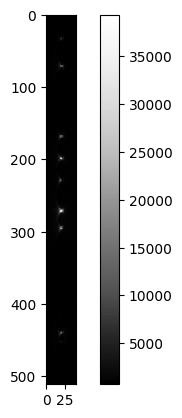

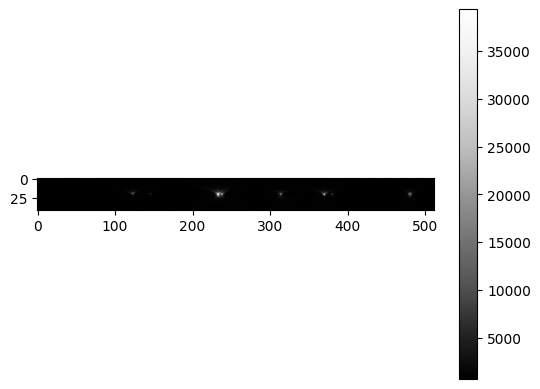

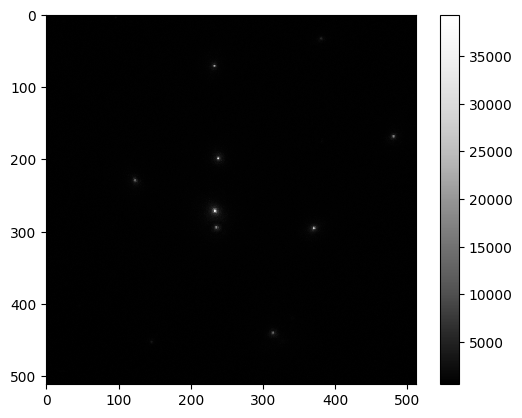

In [25]:
imshow(cle.maximum_x_projection(bead_images[0,]), colorbar=True)
imshow(cle.maximum_y_projection(bead_images[0,]), colorbar=True)
imshow(cle.maximum_z_projection(bead_images[0,]), colorbar=True)

For determining an average PSF, technically we can crop out all the individual beads, align them and then average the images. Therefore, we segment the objects and determine their center of mass.

In [34]:
# ------------- batch mode --------------- #

for iter in range(len(beads_imgpath)):
    # Segment objects
    label_image = cle.voronoi_otsu_labeling(bead_images[iter,])

    # determine center of mass for each object
    stats = cle.statistics_of_labelled_pixels(bead_images[iter,], label_image)

    df = pd.DataFrame(stats)
    df[["mass_center_x", "mass_center_y", "mass_center_z"]]

    ## PSF averaging
    # configure size of future PSF image
    psf_radius = 16
    size = psf_radius * 2 + 1

    # initialize PSF
    single_psf_image = cle.create([size, size, size])
    avg_psf_image = cle.create([size, size, size])

    num_psfs = len(df)
    for index, row in df.iterrows():
        x = row["mass_center_x"]
        y = row["mass_center_y"]
        z = row["mass_center_z"]
        
        print("Bead", index, "at position", x, y, z)
        
        # move PSF in right position in a smaller image
        cle.translate(bead_images[0,], single_psf_image, 
                    translate_x= -x + psf_radius,
                    translate_y= -y + psf_radius,
                    translate_z= -z + psf_radius)

        # # visualize
        # fig, axs = plt.subplots(1,3)    
        # imshow(cle.maximum_x_projection(single_psf_image), plot=axs[0])
        # imshow(cle.maximum_y_projection(single_psf_image), plot=axs[1])
        # imshow(cle.maximum_z_projection(single_psf_image), plot=axs[2])
        
        # average
        avg_psf_image = avg_psf_image + single_psf_image / num_psfs




size: 41
Bead 0 at position 122.888916015625 229.81573486328125 18.252670288085938
Bead 1 at position 232.44996643066406 71.22151947021484 19.892147064208984
Bead 2 at position 233.2019500732422 272.2463073730469 18.502033233642578
Bead 3 at position 235.3282012939453 294.7621154785156 19.04974937438965
Bead 4 at position 238.04478454589844 199.11306762695312 19.179725646972656
Bead 5 at position 313.6776123046875 440.78546142578125 19.865447998046875
Bead 6 at position 370.0578308105469 296.0335998535156 18.952102661132812
Bead 7 at position 380.0908203125 33.51670837402344 20.303314208984375
Bead 8 at position 480.50848388671875 168.71249389648438 19.84193229675293
size: 41
Bead 0 at position 122.888916015625 229.81573486328125 18.252670288085938
Bead 1 at position 232.44996643066406 71.22151947021484 19.892147064208984
Bead 2 at position 233.2019500732422 272.2463073730469 18.502033233642578
Bead 3 at position 235.3282012939453 294.7621154785156 19.04974937438965
Bead 4 at position 

size: 41


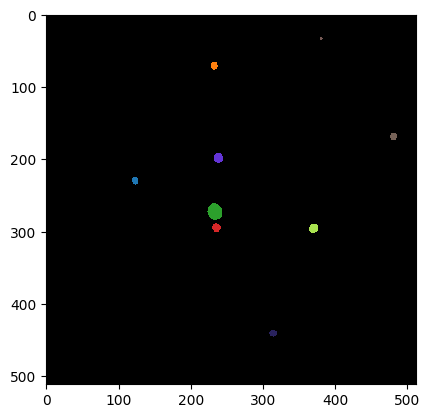

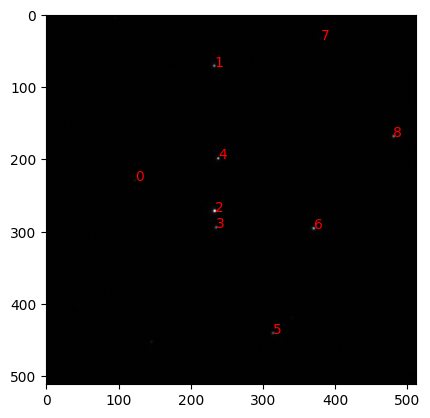

In [30]:
# Segment objects
label_image = cle.voronoi_otsu_labeling(bead_images[0,])
imshow(label_image, labels=True)

# determine center of mass for each object
stats = cle.statistics_of_labelled_pixels(bead_images[0,], label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]

# Convert dataframe to numpy array
centers = df[["mass_center_x", "mass_center_y", "mass_center_z"]].to_numpy()

# Overlay labels on bead_image
fig, ax = plt.subplots()
ax.imshow(bead_images[0,20,:], cmap='gray')
for i, (x, y, z) in enumerate(centers):
    ax.text(x, y, str(i), color='red')  # Assuming mass_center_x corresponds to y and mass_center_y corresponds to x
plt.show()

below are valid beads index for each file based on PSFj, ordered by the file order
[[1,4,5,8]
[0,4]
[1,6,8]
[]
[5]
[0,2,5]
[2,3,4]
[5,6,7]
[0,3,6,8]
[0,1,4,5]]


## PSF averaging
Next, we will iterate over the beads and crop them out by translating them into a smaller PSF image.

Bead 0 at position 122.888916015625 229.81573486328125 18.252670288085938
Bead 1 at position 232.44996643066406 71.22151947021484 19.892147064208984
Bead 2 at position 233.2019500732422 272.2463073730469 18.502033233642578
Bead 3 at position 235.3282012939453 294.7621154785156 19.04974937438965
Bead 4 at position 238.04478454589844 199.11306762695312 19.179725646972656
Bead 5 at position 313.6776123046875 440.78546142578125 19.865447998046875
Bead 6 at position 370.0578308105469 296.0335998535156 18.952102661132812
Bead 7 at position 380.0908203125 33.51670837402344 20.303314208984375
Bead 8 at position 480.50848388671875 168.71249389648438 19.84193229675293


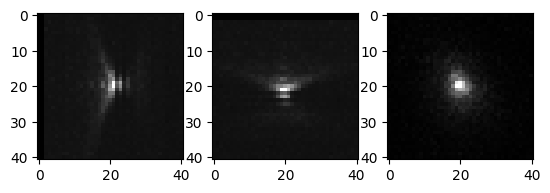

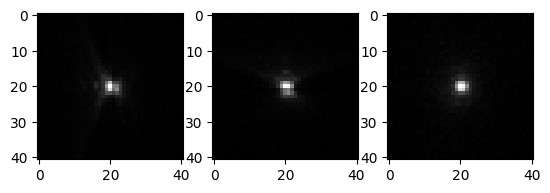

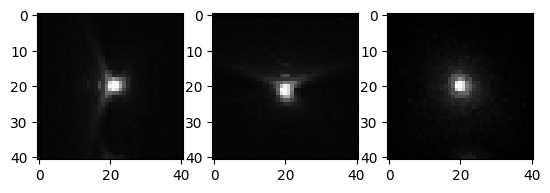

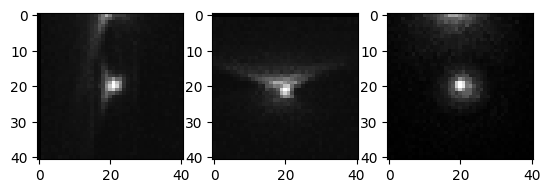

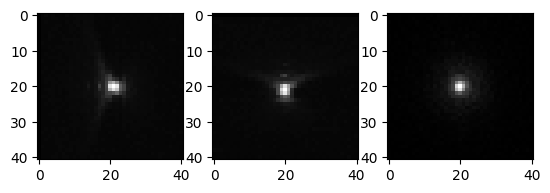

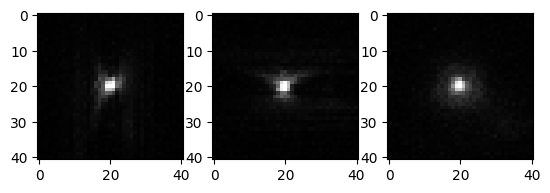

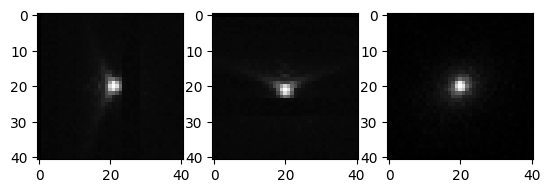

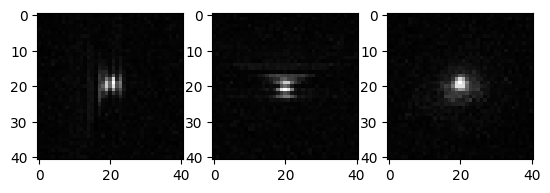

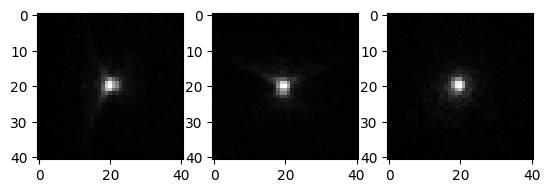

In [31]:
# configure size of future PSF image
psf_radius = 20
size = psf_radius * 2 + 1

# initialize PSF
single_psf_image = cle.create([size, size, size])
avg_psf_image = cle.create([size, size, size])

num_psfs = len(df)
for index, row in df.iterrows():
    x = row["mass_center_x"]
    y = row["mass_center_y"]
    z = row["mass_center_z"]
    
    print("Bead", index, "at position", x, y, z)
    
    # move PSF in right position in a smaller image
    cle.translate(bead_images[0,], single_psf_image, 
                  translate_x= -x + psf_radius,
                  translate_y= -y + psf_radius,
                  translate_z= -z + psf_radius)

    # visualize
    fig, axs = plt.subplots(1,3)    
    imshow(cle.maximum_x_projection(single_psf_image), plot=axs[0])
    imshow(cle.maximum_y_projection(single_psf_image), plot=axs[1])
    imshow(cle.maximum_z_projection(single_psf_image), plot=axs[2])
    
    # average
    avg_psf_image = avg_psf_image + single_psf_image / num_psfs

The average PSF then looks like this:

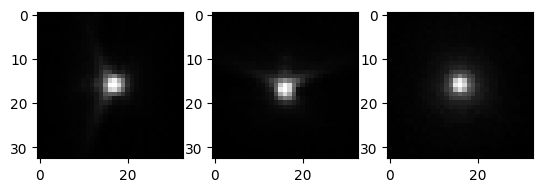

In [35]:
fig, axs = plt.subplots(1,3)    
imshow(cle.maximum_x_projection(avg_psf_image), plot=axs[0])
imshow(cle.maximum_y_projection(avg_psf_image), plot=axs[1])
imshow(cle.maximum_z_projection(avg_psf_image), plot=axs[2])

In [37]:
avg_psf_image.min(), avg_psf_image.max()
print(avg_psf_image.shape)

(33, 33, 33)


After we determined a well centered PSF, we can save it for later re-use. Before doing that, we normalize the PSF. Goal is to have an image where the total intensity is `1`. This makes sure that an image that is deconvolved using this PSF later on does not modify the image's intensity range.

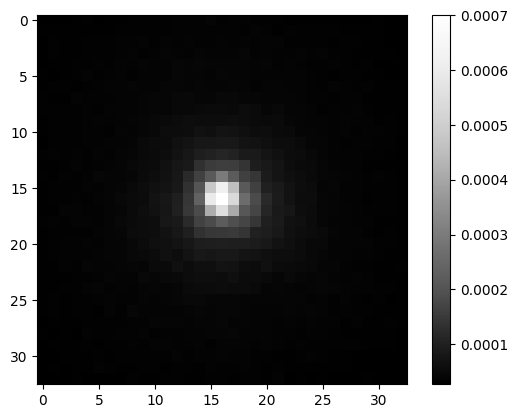

In [46]:
normalized_psf = avg_psf_image / np.sum(avg_psf_image)

imshow(normalized_psf, colorbar=True)

In [42]:
normalized_psf.min(), normalized_psf.max()

(3.365967e-06, 0.00038101437)

In [47]:
imsave('/mnt/disk1/WZH-DataCenter/PROCESS-SPT/2024/20240326_Qdot655/psf.tif', normalized_psf)

/tmp/ipykernel_164974/4156931040.py:1: UserWarning: /mnt/disk1/WZH-DataCenter/PROCESS-SPT/2024/20240326_Qdot655/psf.tif is a low contrast image
  imsave('/mnt/disk1/WZH-DataCenter/PROCESS-SPT/2024/20240326_Qdot655/psf.tif', normalized_psf)
